In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from fitter import Fitter

In [2]:
df = pd.read_parquet(r"../data/types_fixed_german_credit_data.parquet", engine="pyarrow")
cat_cols = {
    "Job": [0, 1, 2, 3],
    "Saving accounts": ['little', 'quite rich', 'rich'], 
    "Risk": ["good", "bad"]
}

for col, categories in cat_cols.items():
    df[col] = pd.Categorical(df[col], categories=categories, ordered=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Duration         4699 non-null   Int64   
 1   Credit amount    4568 non-null   Int64   
 2   Purpose          4686 non-null   category
 3   Job              4635 non-null   category
 4   Sex              4617 non-null   category
 5   Saving accounts  3306 non-null   category
 6   Housing          4622 non-null   category
 7   Risk             4705 non-null   category
 8   Age              4703 non-null   Int64   
 9   Unnamed: 0       4685 non-null   float64 
dtypes: Int64(3), category(6), float64(1)
memory usage: 195.3 KB


Let's get missing values per column

In [4]:
df.isnull().sum()

Duration            147
Credit amount       278
Purpose             160
Job                 211
Sex                 229
Saving accounts    1540
Housing             224
Risk                141
Age                 143
Unnamed: 0          161
dtype: int64

In [5]:
nulls_perc = (df.isnull().sum() / len(df) * 100).round(2)

pd.DataFrame({
    "Null count" : df.isnull().sum(),
    "Null %" : nulls_perc,
    "Dtype": df.dtypes
}) 

,Null count,Null %,Dtype
Duration,147,3.03,Int64
Credit amount,278,5.74,Int64
Purpose,160,3.30,category
Job,211,4.35,category
Sex,229,4.73,category
Saving accounts,1540,31.78,category
Housing,224,4.62,category
Risk,141,2.91,category
Age,143,2.95,Int64
Unnamed: 0,161,3.32,float64


In [6]:
df = df.drop_duplicates(subset=["Unnamed: 0"], keep="first")

In a first run trough I could see that credit amount had some gross outliers, here I remove them for the analysis sake.

In [7]:
def remove_outliers_iqr(df, columns: list[str], n = 1.5):
    temp = df.copy()
    for col in columns:
        q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        iqr = q3 - q1
        
        lower, upper = q1 - n * iqr, q3 + n * iqr
        
        temp = temp[
            (temp[col] >= lower) &
            (temp[col] <= upper)
        ] 
    
    return temp.reset_index(drop=True)

In [8]:
df = remove_outliers_iqr(df, ["Credit amount"], n=3.0)  # removing severe outliers

In [9]:
df.describe()

,Duration,Credit amount,Age,Unnamed: 0
count,896.0,903.0,898.0,903.000000
mean,20.580357,3062.6866,35.538976,502.932447
std,11.621124,2352.646513,11.282584,291.315220
min,4.0,250.0,19.0,0.000000
25%,12.0,1362.5,27.0,246.500000
50%,18.0,2292.0,33.0,509.000000
75%,24.0,3913.5,42.0,758.500000
max,72.0,11998.0,75.0,999.000000


In [10]:
def analyze_categorical_distribution(df, cat_cols):
    """Analyze distribution characteristics of categorical variables"""
    
    results = {}
    for col in cat_cols:
        val_counts = df[col].value_counts()
        proportions = df[col].value_counts(normalize=True)
        
        n_unique = len(val_counts)
        mode = val_counts.index[0]
        mode_percentage = proportions.iloc[0] * 100
        
        freq_array = val_counts.values
        freq_skew = (freq_array.mean() - np.median(freq_array)) / freq_array.std()
        
        results[col] = {
            'Unique Values': n_unique,
            'Mode': mode,
            'Mode %': f"{mode_percentage:.2f}%",
            'Distribution Skew': f"{freq_skew:.2f}",
            'Value Counts': val_counts
        }
    
    return pd.DataFrame(results).T

In [11]:
display(analyze_categorical_distribution(df, df.select_dtypes(include=['category']).columns))

,Unique Values,Mode,Mode %,Distribution Skew,Value Counts
Purpose,12,car,34.08%,0.57,Purpose car 304 radio/TV ...
Job,4,2,64.03%,0.35,Job 2 575 1 181 3 122 0 20 Name: ...
Sex,3,male,69.18%,0.09,Sex male 615 female 274 353546 0 ...
Saving accounts,3,little,84.54%,0.69,Saving accounts little 536 quite rich ...
Housing,6,own,71.59%,0.45,Housing own 640 rent 159 free 94 43...
Risk,2,good,70.70%,0.00,"Risk good 625 bad 259 Name: count, dtyp..."


In [12]:
def analyze_numerical_dist(df, num_cols: list):
    results = {}
    for col in num_cols:
        val_counts = df[col].value_counts()
        freq_array = val_counts.values
        freq_skew = (freq_array.mean() - np.median(freq_array)) / freq_array.std()
        
        dist = Fitter(df[col].dropna().astype("float32").values)
        dist.fit()
        
        results[col] = {
            'Unique Values' : len(val_counts),
            'Distribution Skew' : f"{freq_skew:.2f}",
            'Distribution Type' : f"{dist.get_best(method='sumsquare_error')}"
        }
    
    return pd.DataFrame(results).T

In [13]:
display(analyze_numerical_dist(df, df.select_dtypes(include=['int']).columns))

,Unique Values,Distribution Skew,Distribution Type
Duration,33,0.47,{'laplace_asymmetric': {'kappa': 0.53276407455...
Credit amount,838,0.28,"{'exponnorm': {'K': 8.362567842186058, 'loc': ..."
Age,53,0.29,"{'skewnorm': {'a': 12.502334874493274, 'loc': ..."


# Univariate analysis 

## Numerical columns

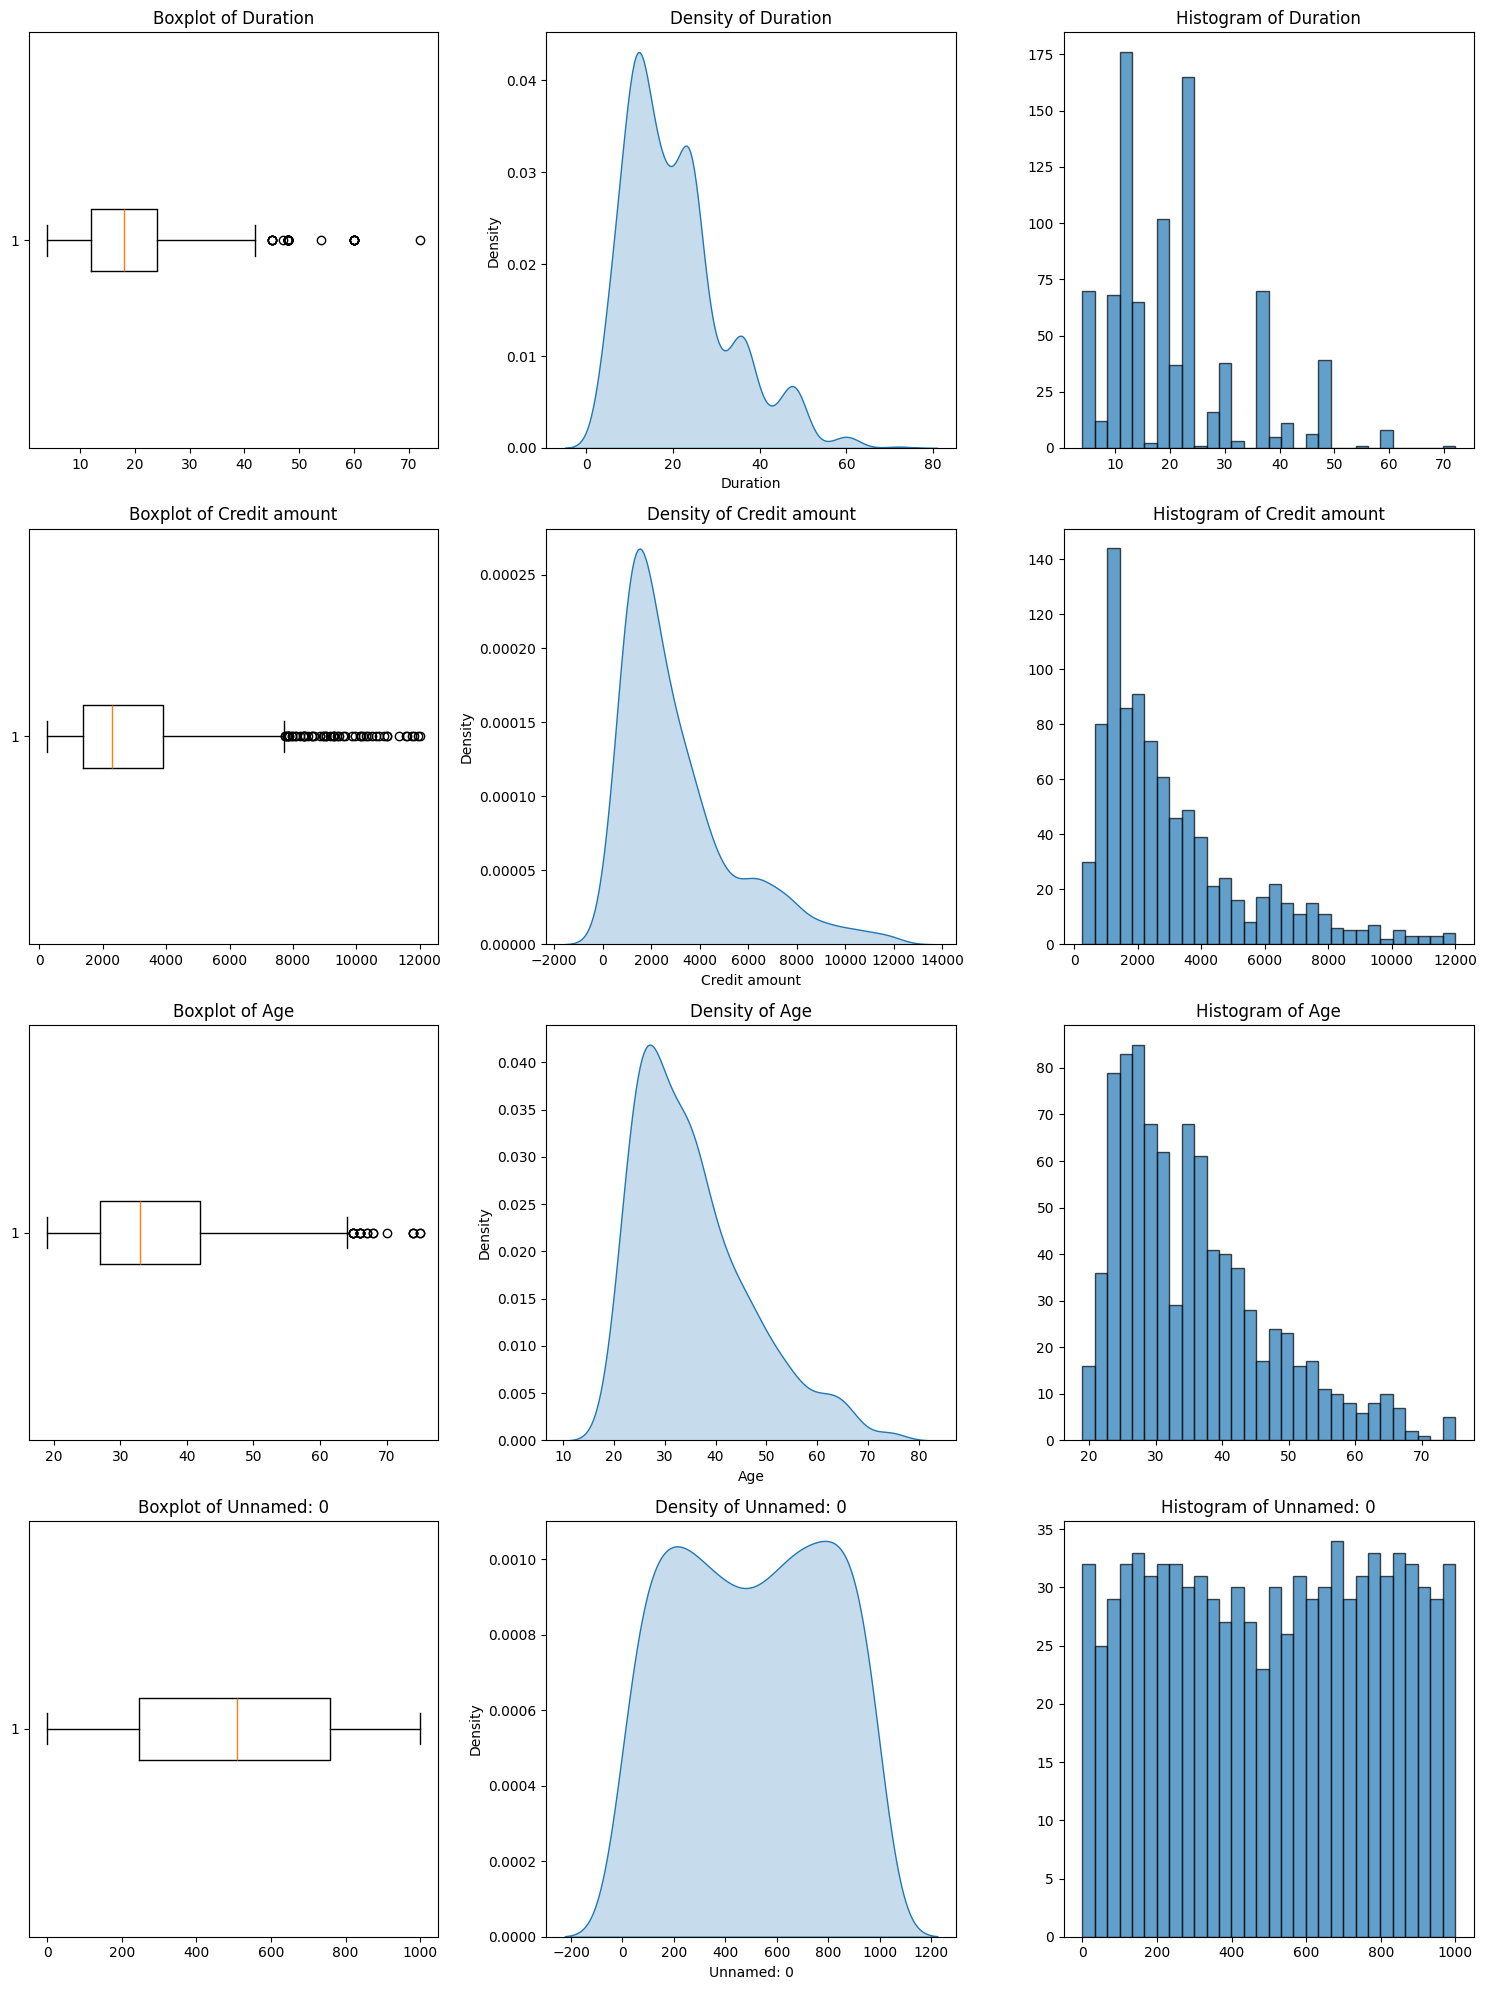

In [14]:
num_cols = list(df.select_dtypes(include=["number"]).columns)

fig, axes = plt.subplots(nrows=len(num_cols), ncols=3, figsize=(15, 5 * len(num_cols)))

for i, col in enumerate(num_cols):
    axes[i, 0].boxplot(df[col].dropna(), vert=False)
    axes[i, 0].set_title(f"Boxplot of {col}")

    # Density plot (approximation using histogram)
    sns.kdeplot(df[col], fill=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Density of {col}")

    # Histogram
    axes[i, 2].hist(df[col].dropna(), bins=30, edgecolor="black", alpha=0.7)
    axes[i, 2].set_title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

## Categorical variables

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Duration         896 non-null    Int64   
 1   Credit amount    903 non-null    Int64   
 2   Purpose          892 non-null    category
 3   Job              898 non-null    category
 4   Sex              889 non-null    category
 5   Saving accounts  634 non-null    category
 6   Housing          894 non-null    category
 7   Risk             884 non-null    category
 8   Age              898 non-null    Int64   
 9   Unnamed: 0       903 non-null    float64 
dtypes: Int64(3), category(6), float64(1)
memory usage: 37.5 KB


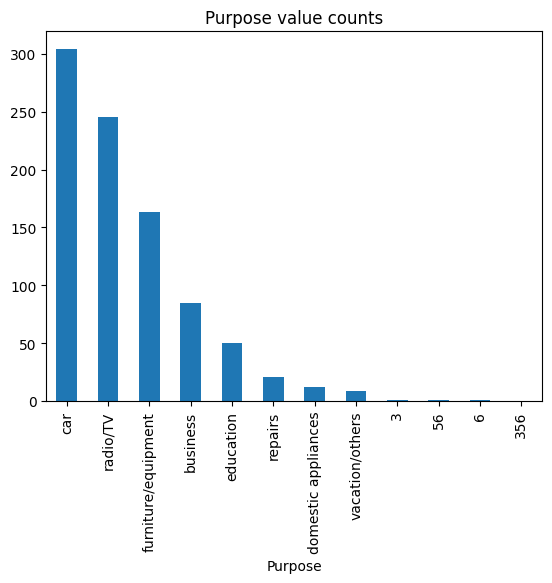

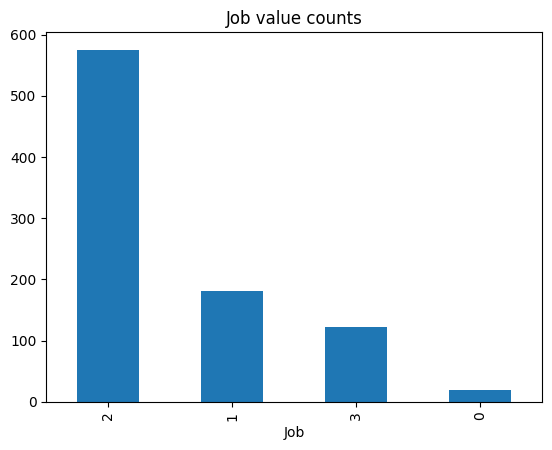

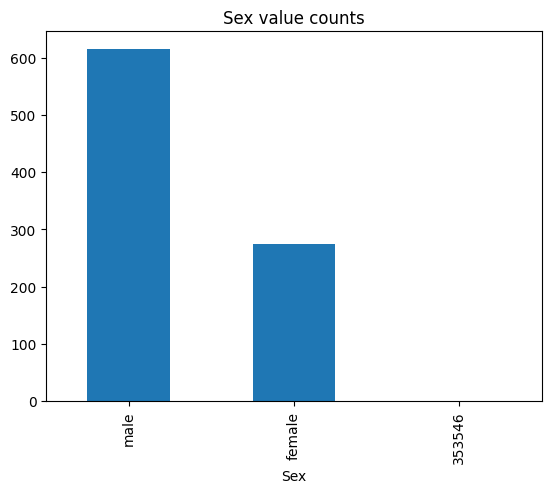

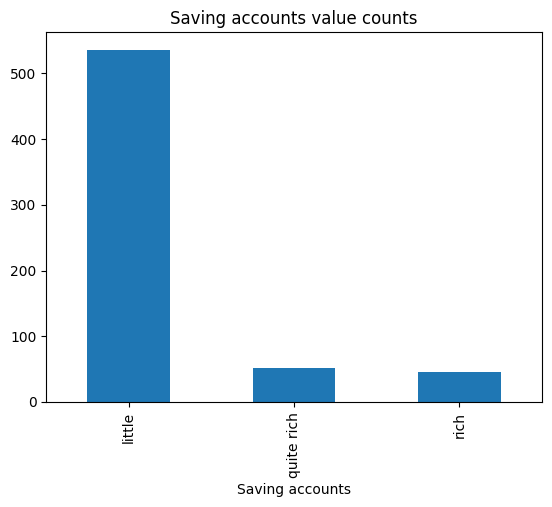

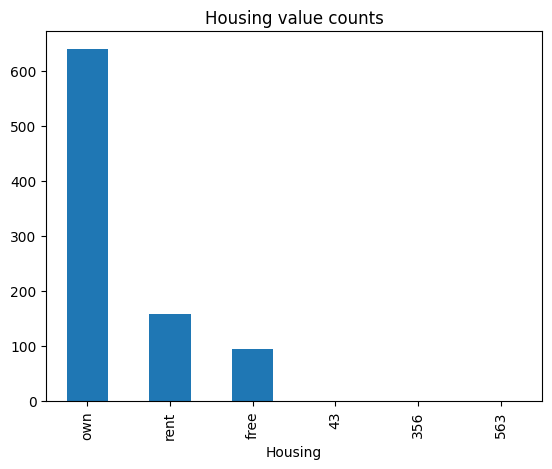

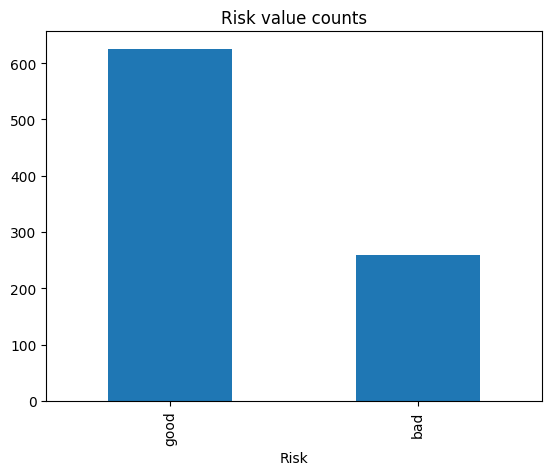

In [16]:
cat_cols = list(df.select_dtypes(include=["category"]).columns)

for col in cat_cols:
    df[col].value_counts().plot(
        kind="bar", title = f"{col} value counts"
    )
    plt.show()

# Bivariate analysis

## Target vs numerical vars

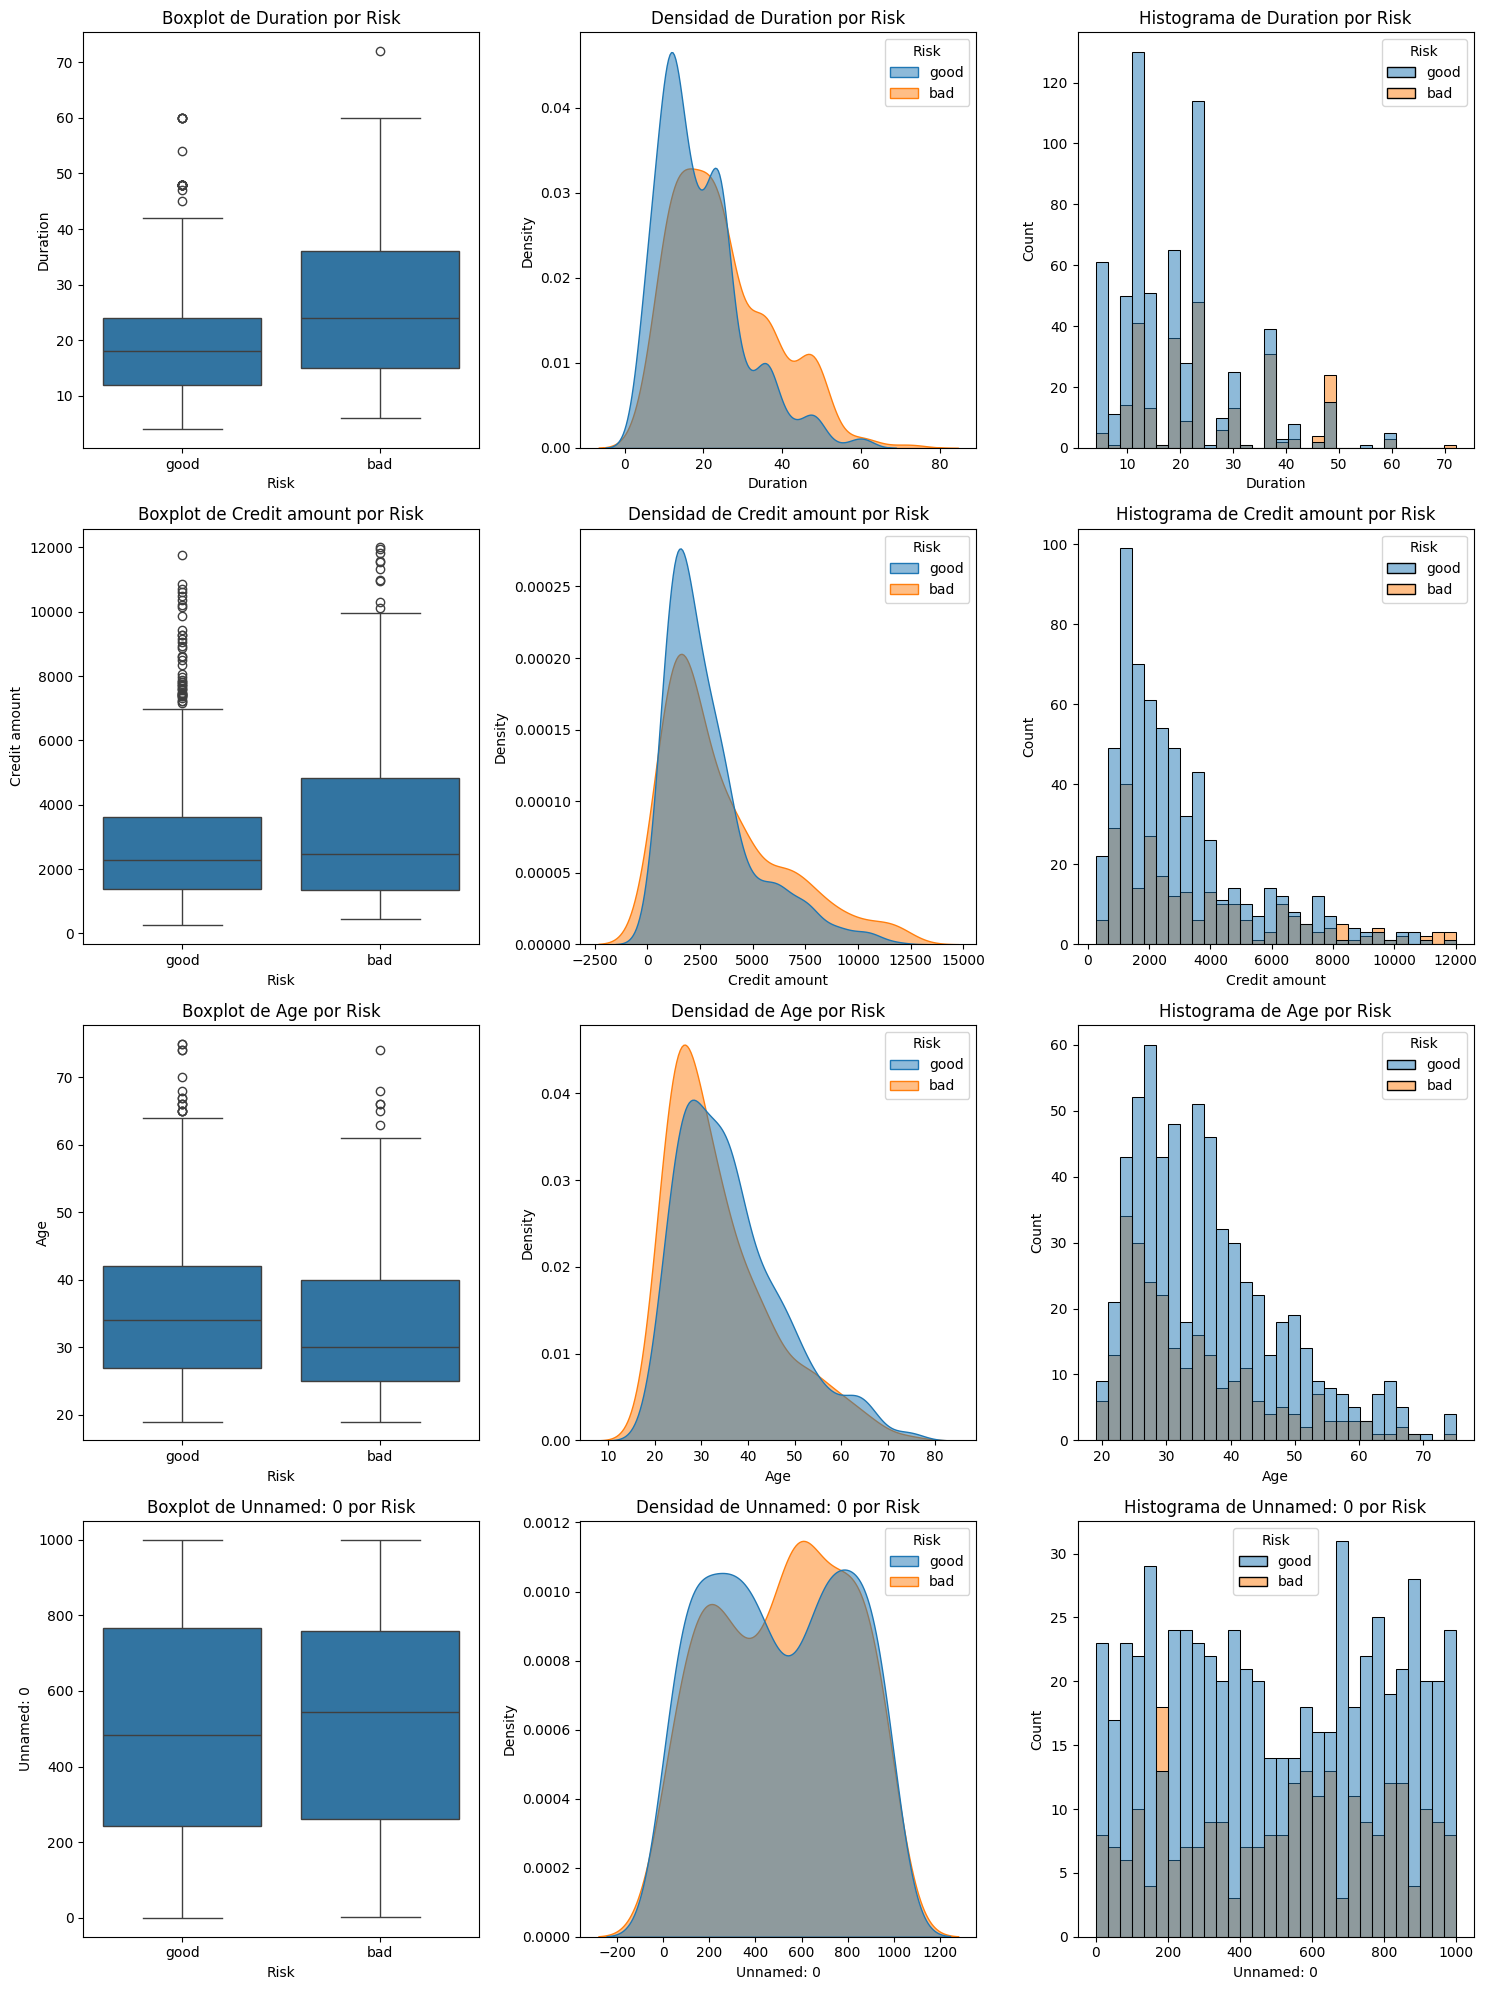

In [17]:
fig, axes = plt.subplots(nrows=len(num_cols), ncols=3, figsize=(15, 5 * len(num_cols)))

for i, col in enumerate(num_cols):
    sns.boxplot(x="Risk", y=col, data=df, ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot de {col} por Risk")
    
    sns.kdeplot(data=df, x=col, hue="Risk", fill=True, common_norm=False, alpha=0.5, ax=axes[i, 1])
    axes[i, 1].set_title(f"Densidad de {col} por Risk")
    
    sns.histplot(data=df, x=col, hue="Risk", bins=30, kde=False, alpha=0.5, ax=axes[i, 2])
    axes[i, 2].set_title(f"Histograma de {col} por Risk")

plt.tight_layout()
plt.show()

It can be seen that the Age and Risk are not related, they don't seem to share a trend. However, credit amount and duration do share a trend with the risk of the credit, it seems that the bigger the duration or the amount of the credit is more likely that is a bad risk. 

## Target vs categorical vars

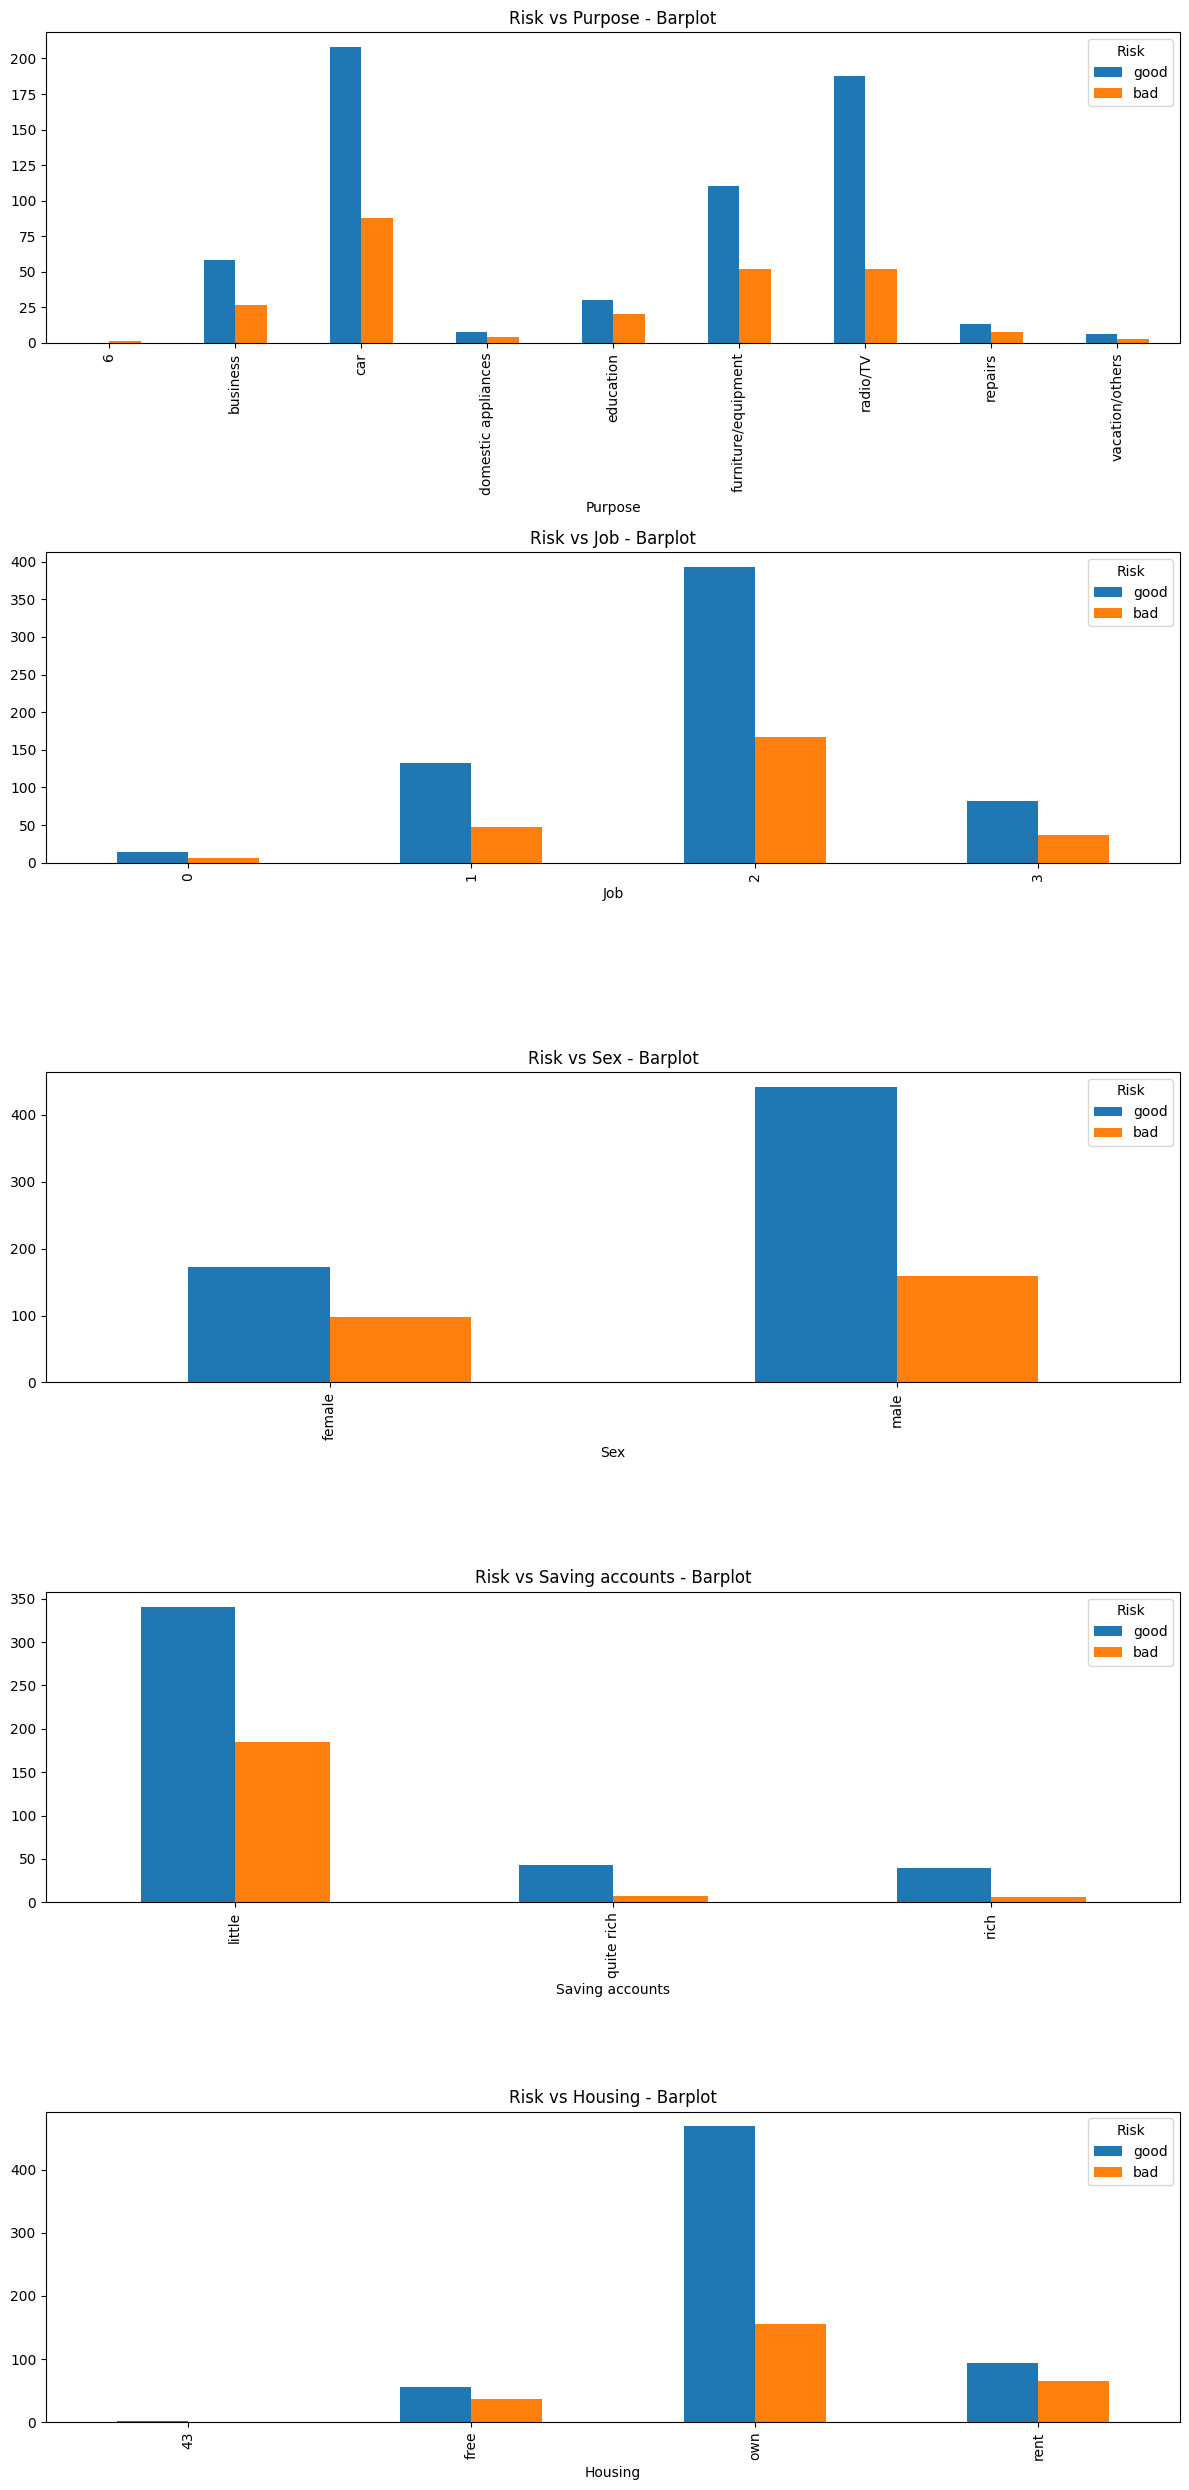

In [18]:
cat_cols = [col for col in cat_cols if col != "Risk"]

fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(12, 5 * max(len(cat_cols), 1)))

for i, col in enumerate(cat_cols):
    pd.crosstab(df[col], df["Risk"]).plot(
        kind="bar",
        ax=axes[i],
        title=f"Risk vs {col} - Barplot"
    )
plt.tight_layout()
plt.show()

In [19]:
target = df["Risk"]

temp = df.copy()
temp["Risk"] = temp["Risk"].apply(lambda x: 1 if x == "good" else 0).astype("float64")

for col in cat_cols:
    heatmap = (
        pd.crosstab(df[col], target, margins=True)
        .style.background_gradient(cmap="coolwarm")
        .set_caption(f"Risk vs {col} Heatmap")
    )
    display(heatmap)
    display(temp.groupby(col, observed=True).agg({"Risk": "mean"}) * 100)
    

Risk,good,bad,All
Purpose,,,
6,0,1,1
business,58,27,85
car,208,88,296
domestic appliances,8,4,12
education,30,20,50
furniture/equipment,110,52,162
radio/TV,188,52,240
repairs,13,8,21
vacation/others,6,3,9


,Risk
Purpose,
3,NaN
56,NaN
6,0.000000
business,68.235294
car,70.270270
domestic appliances,66.666667
education,60.000000
furniture/equipment,67.901235
radio/TV,78.333333


Risk,good,bad,All
Job,,,
0,14,6,20
1,132,48,180
2,393,167,560
3,82,37,119
All,621,258,879


,Risk
Job,
0,70.000000
1,73.333333
2,70.178571
3,68.907563


Risk,good,bad,All
Sex,,,
female,173,98,271
male,442,159,601
All,615,257,872


,Risk
Sex,
female,63.837638
male,73.544093


Risk,good,bad,All
Saving accounts,,,
little,341,185,526
quite rich,43,7,50
rich,40,6,46
All,424,198,622


,Risk
Saving accounts,
little,64.828897
quite rich,86.000000
rich,86.956522


Risk,good,bad,All
Housing,,,
43,1,0,1
free,56,37,93
own,469,156,625
rent,93,65,158
All,619,258,877


,Risk
Housing,
43,100.000000
free,60.215054
own,75.040000
rent,58.860759


A good first heuristic, for what's shown in the data would be to tag as good credit all credits that have own housing, that are for radio/tv or car, or they have a savings acoount rich or quite rich.

## Numerical vs numerical

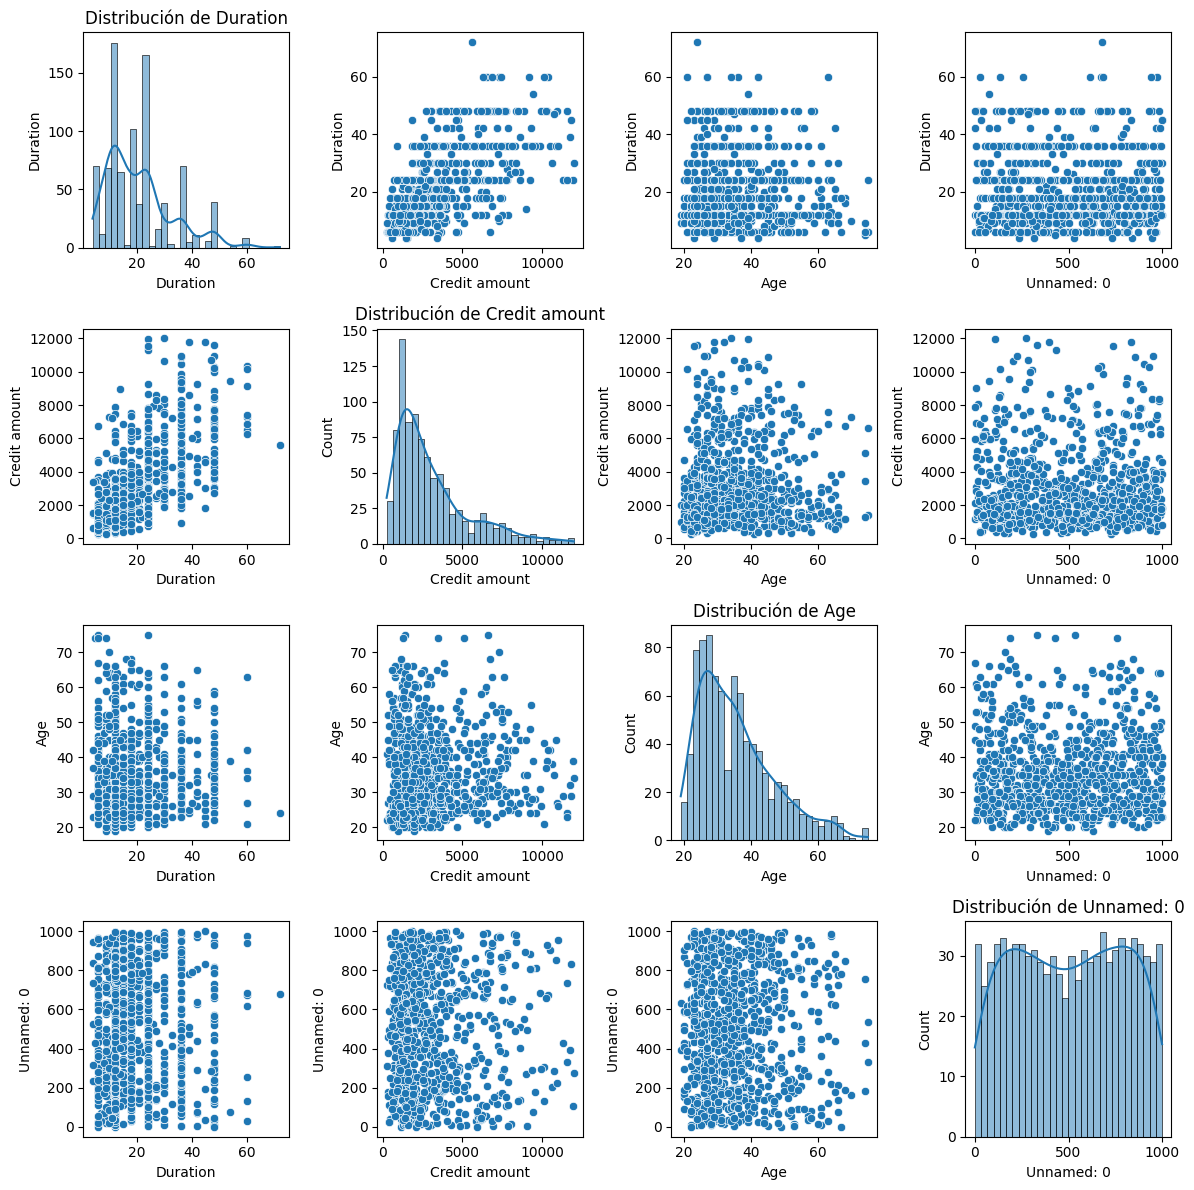

In [20]:
num_vars = len(num_cols)
fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=(3 * num_vars, 3 * num_vars))

for i, col1 in enumerate(num_cols):
    for j, col2 in enumerate(num_cols):
        ax = axes[i, j]
        if i == j:
            sns.histplot(df[col1], bins=30, kde=True, ax=ax)
            ax.set_title(f"Distribución de {col1}")
        else:
            sns.scatterplot(x=df[col2], y=df[col1], ax=ax)
        
        if j == 0:
            ax.set_ylabel(col1)
        if i == num_vars - 1:
            ax.set_xlabel(col2)
plt.tight_layout()
plt.show()

This distributions don't tell me a lot, rather than a "linear" relation between credit amount and duration which makes sense. 

## Categorical vs categorical

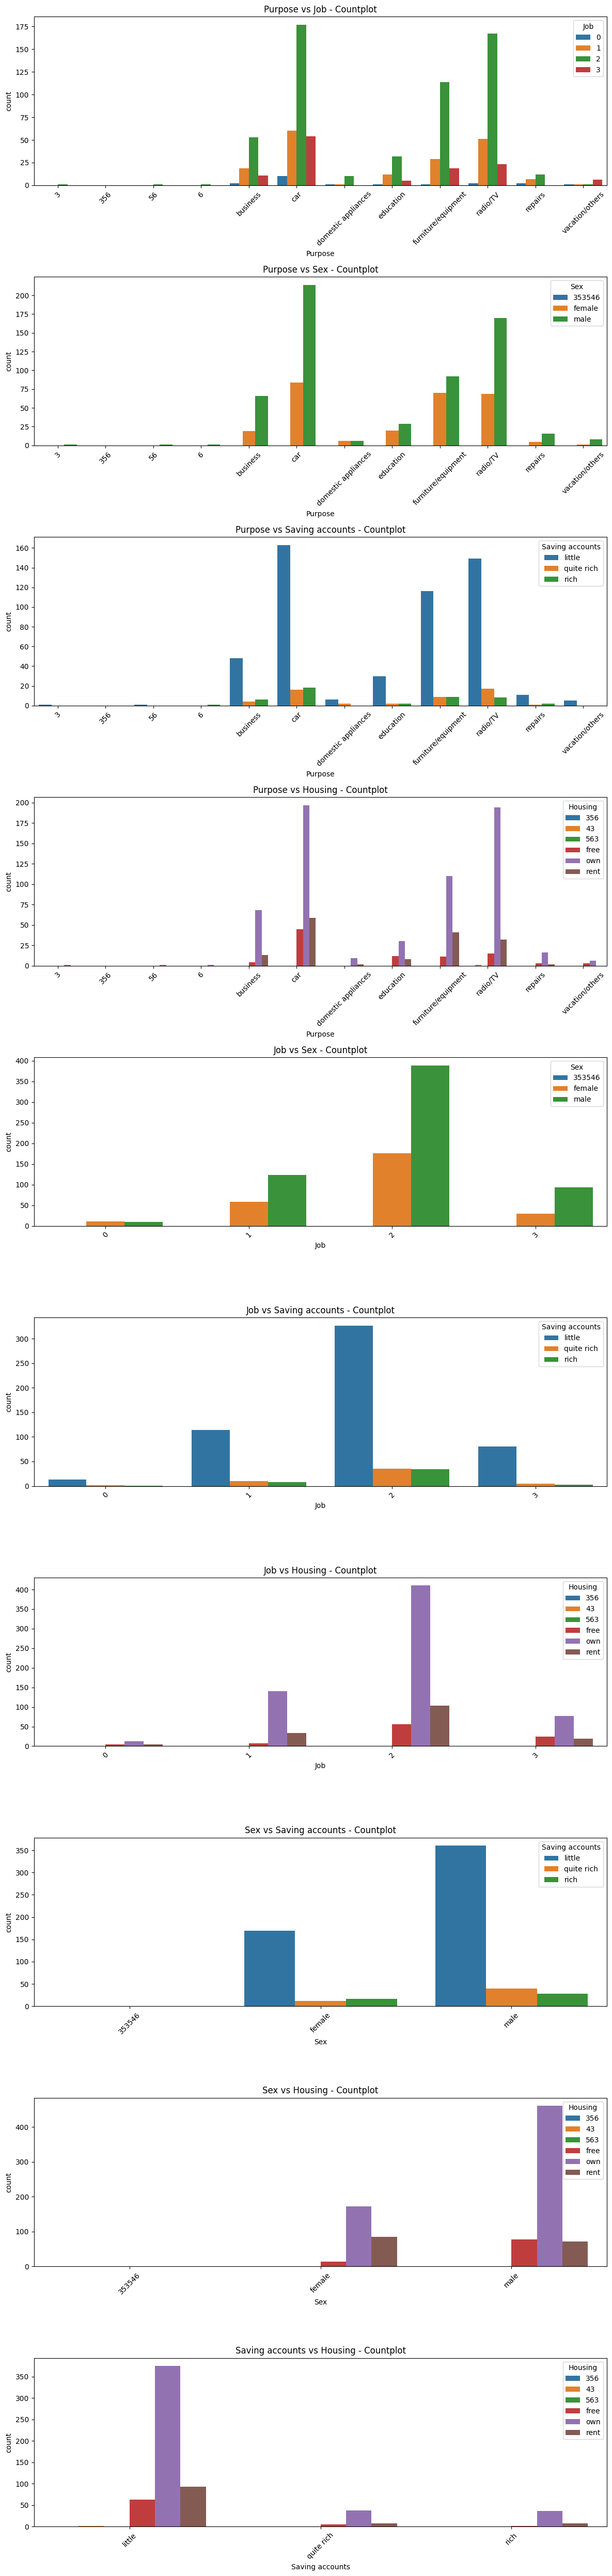

In [21]:
cat_combinations = list(combinations(cat_cols, 2))
num_plots = len(cat_combinations)

fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, 5 * max(num_plots, 1)))

for i, (col1, col2) in enumerate(cat_combinations):
    sns.countplot(data=df, x=col1, hue=col2, ax=axes[i])
    axes[i].set_title(f"{col1} vs {col2} - Countplot")
    axes[i].tick_params(axis='x', rotation=45) 
plt.tight_layout()
plt.show()

## Categorical vs numerical

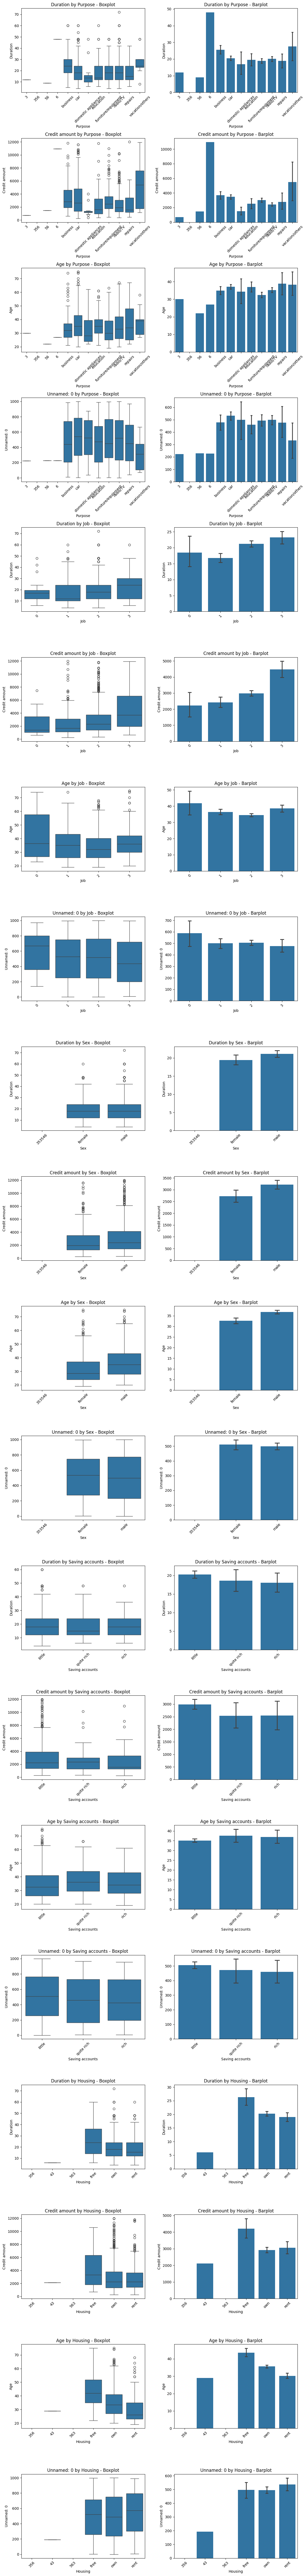

In [22]:
combinations = [(cat, num) for cat in cat_cols for num in num_cols]
num_plots = len(combinations)

fig, axes = plt.subplots(nrows=num_plots, ncols=2, figsize=(12, 5 * num_plots))

for i, (cat, num) in enumerate(combinations):
    sns.boxplot(data=df, x=cat, y=num, ax=axes[i][0])
    axes[i][0].set_title(f"{num} by {cat} - Boxplot")
    axes[i][0].tick_params(axis='x', rotation=45)
    
    sns.barplot(data=df, x=cat, y=num, errorbar="ci", capsize=0.1, ax=axes[i][1])
    axes[i][1].set_title(f"{num} by {cat} - Barplot")
    axes[i][1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

It seems that **age** and the **housing** type have some correlation.

# Multivariate analysis

## Numerical vs all numerical

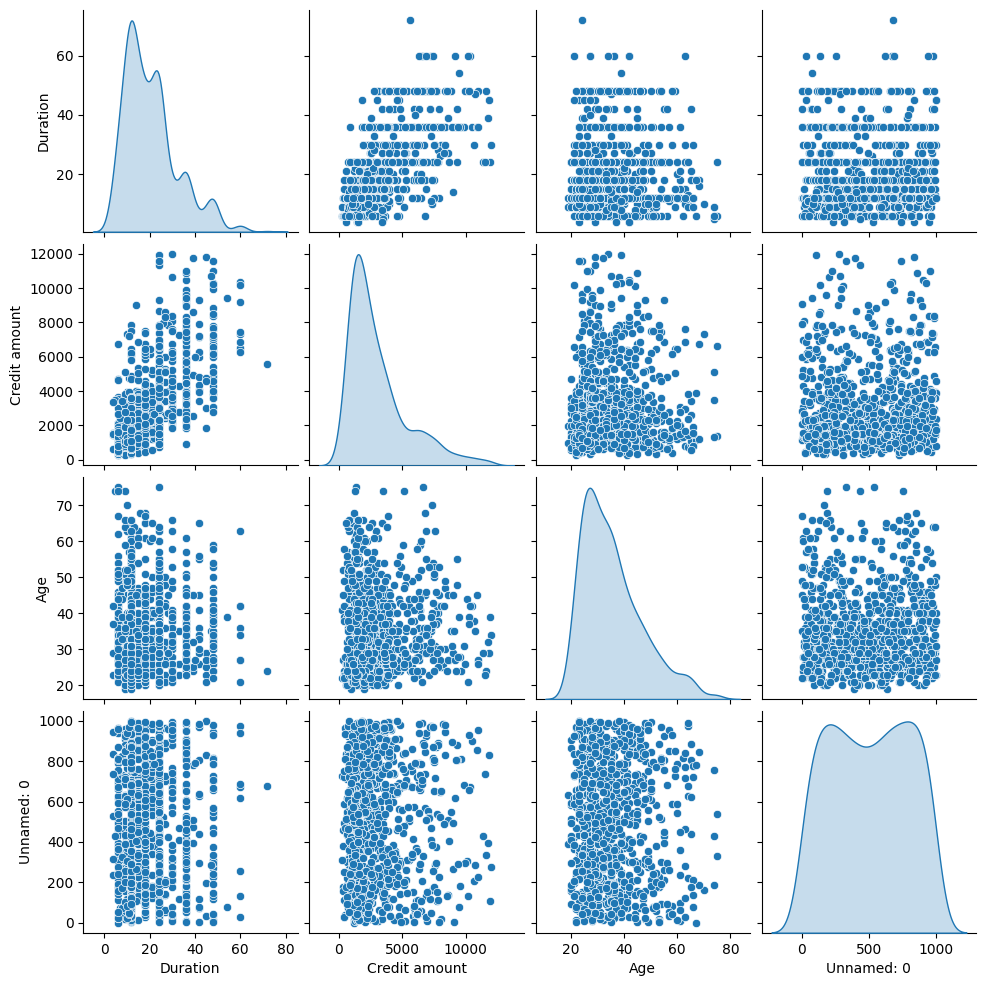

In [23]:
sns.pairplot(df[num_cols], diag_kind="kde")

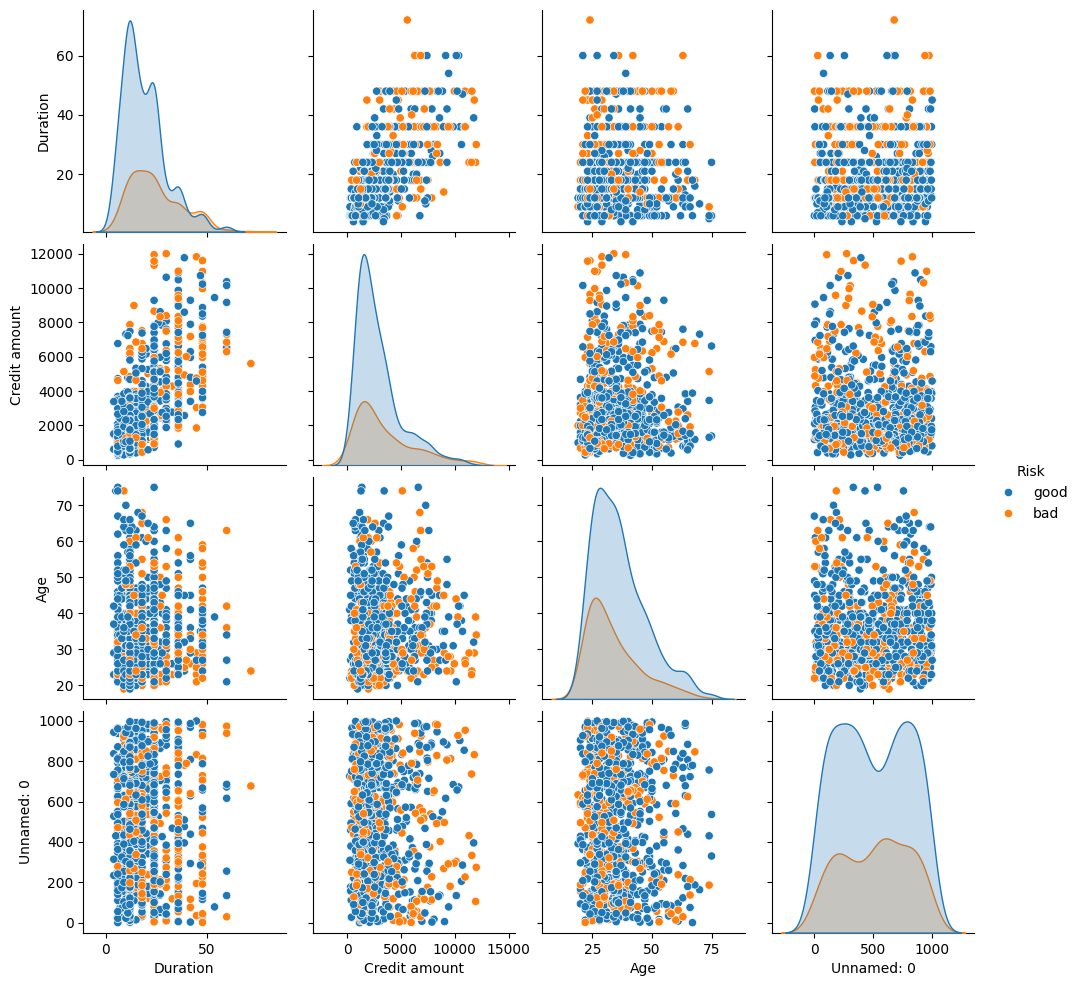

In [24]:
risk = df[[*num_cols, "Risk"]]
sns.pairplot(risk, hue="Risk", diag_kind="kde")

# A simple viable model

In [25]:
def determine_risk(housing: str, purpose: str, saving_accounts: str, credit_amount: int):
    """
    Tags as good credit all credits that have own housing, that are for radio/tv or car,
    or they have a savings acoount rich or quite rich.
    """
    return 1 if (housing == "own" and credit_amount <= 3900) or (purpose == "radio/TV" or purpose == "car") or (saving_accounts != 'little') else 0

In [26]:
test = df.copy()

test = test.dropna()
test["Risk"] = test["Risk"].map({"good": 1, "bad": 0}).astype("int8")

test["heuristic_risk"] = test.apply(lambda row: determine_risk(row["Housing"], row["Purpose"], row["Saving accounts"], row["Credit amount"]), axis=1)

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
y_true, y_pred = test["Risk"], test["heuristic_risk"]

0.6893687707641196

Not bad for a set of simple rules, better than tossing a coin.

In [29]:
print(classification_report(y_true, y_pred, target_names=["bad", "good"]))

              precision    recall  f1-score   support

         bad       0.53      0.28      0.37       194
        good       0.72      0.88      0.79       408

    accuracy                           0.69       602
   macro avg       0.63      0.58      0.58       602
weighted avg       0.66      0.69      0.66       602



In [30]:
confusion_matrix(y_true, y_pred)

array([[ 54, 140],
       [ 47, 361]], dtype=int64)

# Conclusions

- Duration and Credit amount are overall correlated.
- Age and Housing type have got some correlation aswell.
- A vast majority of the credit requests that have quite rich (86%) or rich (87%) Saving accounts are good risk.
- For a base model, and a first try I think **Credit ammount, housing, purpose and saving accounts** features are good enough. 
- A usable simple viable model was formed using the features mentioned above. 
- **Housing** feature has got some categories I'll need to drop: **356, 43, 563**. 
- **Sex** feature has got a category I'll need to drop: **353546**.
- **Purpose** feature has got some categories I'll need to drop: **3, 356, 56, 6**. 